<h1>KNN Undersampling</h1>

<p>This notebook provides a Python function with the implementation of KNN Undersampling, and also shows an experiment with classification improvements after preparing the Pima dataset with the proposed methodology.
</p>

<p>Paper Abstract</p>
<p>In supervised learning, the imbalanced number of instances among the classes in a dataset can
make the algorithms to classify one instance from the minority class as one from the majority class.
With the aim to solve this problem, the KNN algorithm provides a basis to other balancing methods.
These balancing methods are revisited in this work, and a new and simple approach of KNN
undersampling is proposed. The experiments demonstrated that the KNN undersampling method
outperformed other sampling methods. The proposed method also outperformed the results of
other studies, and indicates that the simplicity of KNN can be used as a base for efficient algorithms
in machine learning and knowledge discovery.<p>

<p>For more details about the KNN Undersampling, please visit: <a href="https://file.scirp.org/pdf/JILSA_2015111114204642.pdf">Beckmann, M., Ebecken, N.F.F.,de Lima, B.S.L.B.P. 2015, A KNN Undersampling Approach for Data Balancing</a>.</p>


# Some Basic Imports and Setup

In [3]:
import numpy as np
import pandas as pd
from sklearn.metrics import pairwise
from sklearn.neighbors import NearestNeighbors

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

#For experiment reproduction
np.random.seed(7)

# Loading and Visualizing the Data

C:\Users\beckmann\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\beckmann\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


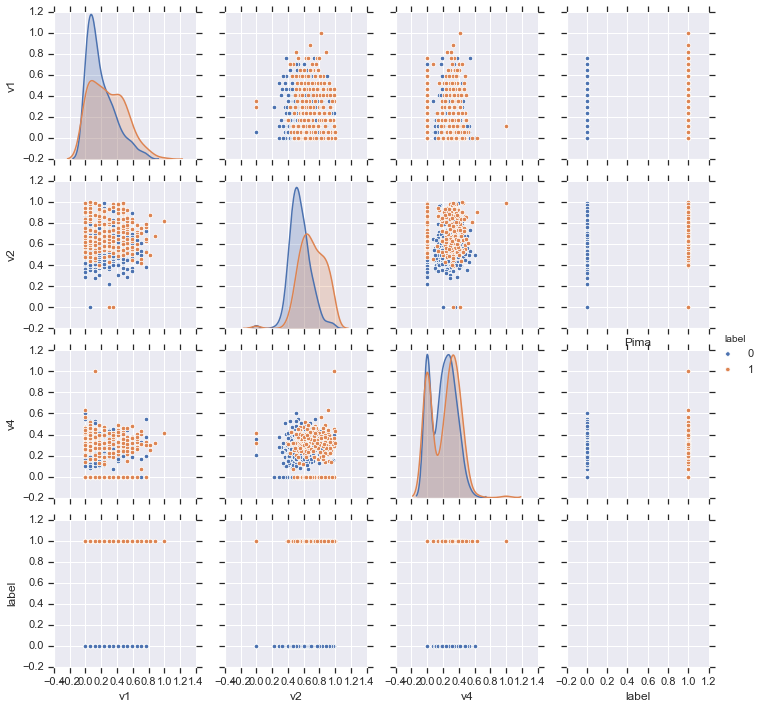

In [4]:

data=pd.read_csv('pima-indians-diabetes_normalize.csv', sep=',')

# Spliting in X,y, training, and test
X=data.drop("label",axis=1)
y = data.label
x_train, x_test, y_train, y_test = train_test_split(X,y, test_size=0.33)

#plot some pairs of variables
_ = sns.pairplot(data.iloc[:,data.columns.get_indexer(["v1","v2","v4","label"])],hue="label")
plt.title("Pima")
plt.show()

# Execute a Naive Bayes Baseline Classification on the Original Data

In [5]:
from sklearn.naive_bayes import GaussianNB
np.random.seed(7)

gnb = GaussianNB()
model = gnb.fit(x_train,y_train)

predictions= model.predict(x_test)

auc_baseline=roc_auc_score(y_test,predictions)

print("Bayes, AUC: " + str(auc_baseline))


Bayes, AUC: 0.7242351046698873


# The KNN Undersampling Function

In [6]:

def knn_und(X,y,majority_class, k=7, t=5, algorithm="auto", metric="euclidean"):
    """Implementation of KNN Undersampling method for class undsersampling adjustment.
               
    Parameters
    ----------
    X : array-like, or pandas.DataFrame, shape (n_samples, n_features)
    Represents the data to be searched.

    Y :  array-like, or pandas.DataFrame, shape (n_samples, 1)
    The labels to X.
    
    k : optional int
    The number of nearest neighbors.
    
    t : optional int
    The threshold number of minority neighbors in order a majority example
    to be considered a noise, and marked to be removed.
    
    Returns
    -------
    undersampling_flags : ndarray, boolean, shape (n_samples, 1)
    Indicates with True/False if an example will be not removed/removed, given the developed
    heuristic.
    
    Reference
    ---------
    Beckmann, M., Ebecken, N.F.F.,de Lima, B.S.L.B.P. 2015, A KNN Undersampling Approach for Data Balancing,
    JILSA - Journal of Intelligent Learning Systems and Applications, 2015, 7, 104-116.
    
    """
    #TODO IMPLEMENT SUPPORT FOR SPARSE MATRICES
    if not isinstance(X, (np.ndarray, np.generic) ):
        X = np.asarray(X)

    if not isinstance(y, (np.ndarray, np.generic) ):
        y = np.asarray(y)
        
    
    
    nrows, ncols = X.shape

    result= [True] * nrows

    nbrs = NearestNeighbors(n_neighbors=k,algorithm="auto", metric=metric).fit(X)
    nns_indexes = nbrs.kneighbors(X,return_distance=False)
   
    for i in range(nrows):
        example = X[i,1:ncols]
        current_label = y[i]
    
        if (current_label != majority_class):
            result[i]=True
            continue

        nns_labels=y[nns_indexes[i]]
        
        num_of_minority = 0
    
        for nn_label in nns_labels:
            if nn_label==i:
                continue

            if nn_label!=majority_class:
                num_of_minority = num_of_minority+1
      
    
        if num_of_minority>t:
            result[i]=False
        else:
            result[i]=True

    return(result)

# Run the KNN Undersampling Cleanup

In [39]:
print("Shape before: ", x_train.shape)

result=knn_und(x_train, y_train,majority_class=0, k=13, t=2)

x_train_cleaned=x_train.iloc[result,:]
y_train_cleaned=y_train.iloc[result]

# Print the shape of cleaned data
print("Shape after: ",x_train_cleaned.shape)

#TODO TEST SPARSE MATRICES

Shape before:  (514, 8)
Shape after:  (366, 8)


# Run the Naive Bayes Classification Again, using the cleaned training set and the original test set 

In [40]:
np.random.seed(7)
gnb = GaussianNB()
model = gnb.fit(x_train_cleaned,y_train_cleaned)

predictions= model.predict(x_test)
auc=roc_auc_score(y_test,predictions)



print("Previous Bayes, AUC: ", auc_baseline)
print("Bayes, AUC after KNN-Und: " ,auc)
print("AUC gain: " ,auc-auc_baseline)




Previous Bayes, AUC:  0.7242351046698873
Bayes, AUC after KNN-Und:  0.7372517444981213
AUC gain:  0.013016639828233978


<h1>Conclusion</h1>

<p>When applied the KNN-Und, the Naive Bayes had a AUC gain of 0.013, (1.3%), 
if compared with the Naive Bayes classification without the data balancing method.</p>